# Introduction to the Spectral Hourglass Pipeline in Python

The Spectral Hourglass Workflow is a structured approach for analyzing hyperspectral and multispectral data. This tutorial is designed to guide you through the key steps of the workflow, which uses many fundamental concepts in spectral image analysis. 

## Objectives

By the end of this tutorial, you will be able to:
- Understand the purpose and application of the ENVI Spectral Hourglass Workflow.
- Perform data pre-processing, including radiometric and atmospheric corrections.
- Conduct spectral data reduction using techniques like Minimum Noise Fraction (MNF) transformation.
- Apply pixel purity indexing (PPI) to identify endmember spectra.
- Use n-Dimensional visualization to refine endmembers.
- Execute spectral unmixing to map mineral distributions and other surface compositions.

## Workflow Overview

The ENVI Spectral Hourglass Workflow consists of the following main steps:

1. **Data Pre-processing**
   - Know your dataset
      - Has it been calibrated and atmospherically corrected?
   - NaN Handling
   - Filtering

2. **Data Reduction**
   - Spectral Dimension Reduction:
      - Minimum Noise Fraction (MNF) Transformation
   - Spatial Dimension Reduction:
      - Pixel Purity Index (PPI)

3. **Endmember Extraction**
   - n-Dimensional Visualization

4. **Classification and Mapping**
   - Spectral Angle Mapper (SAM)
   - Neural Network Classifier (Muli-Layer Perceptron, MLP)

## Load and display the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


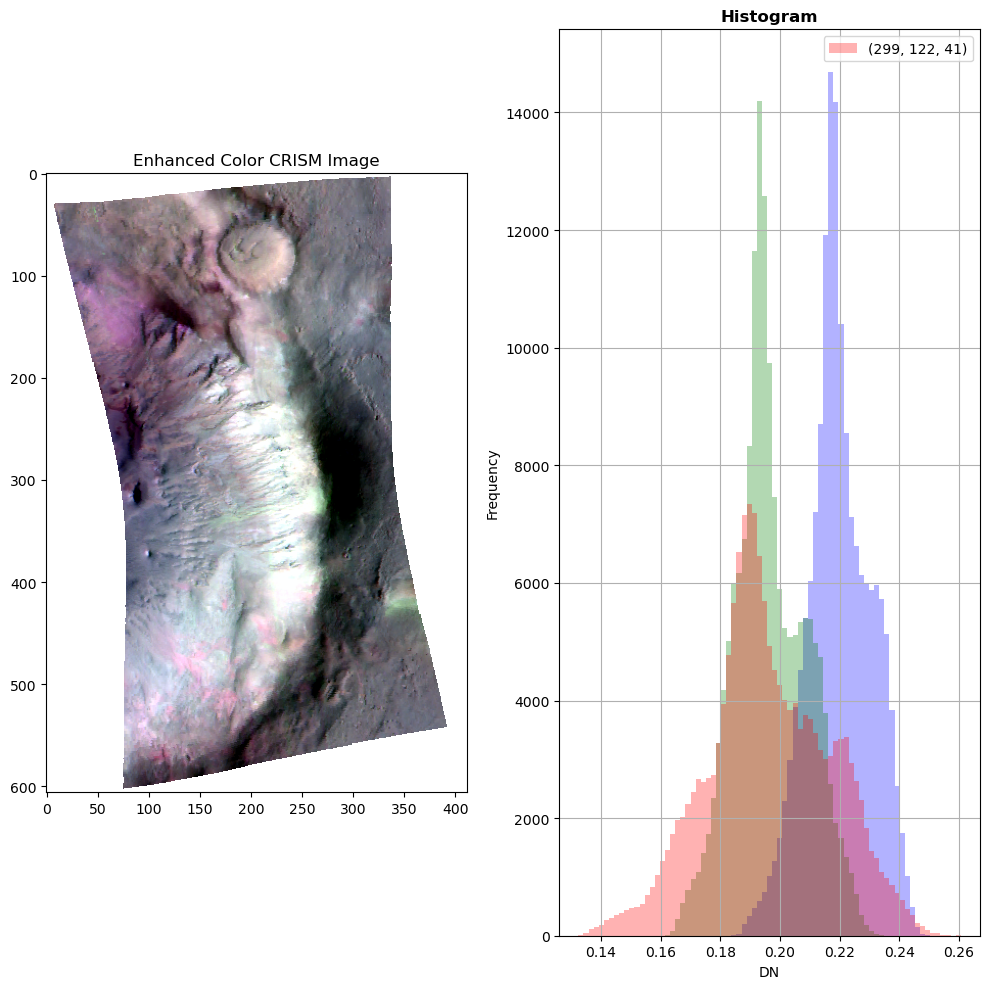

In [1]:
import rasterio
from rasterio.plot import show, show_hist
import numpy as np
import matplotlib.pyplot as plt


# Define the file path for the hyperspectral or multispectral image
file_path = '/Users/shane/Desktop/cartorder/hrl000109e2_07_if181j_mtr3.img'

# Function to read the image data
def read_image(file_path):
    img_obj = rasterio.open(file_path)
    return img_obj

# format the band names in a dictionary
def get_band_names(img_obj):
    bands_dict = {}
    for i, name in enumerate(img_obj.descriptions):
        bands_dict[i] = name
    return bands_dict

# translate CRISM NaN values to np.nan, convert anomalous pixels to np.nan
def clean_crism(img_data):
    # set CRISM nan to np.nan
    img_data[img_data == 65535] = np.nan
    img_data = np.where(img_data < 0, np.nan, img_data)
    img_data = np.where(img_data > 1, np.nan, img_data)
    return img_data

# function to apply 2% stretch
def stretch_bands(arr, min_percentile=2, max_percentile=98):
    if len(arr.shape) > 2:
        for b in range(arr.shape[2]):
            min_val = np.nanpercentile(arr[:,:,b], min_percentile)
            max_val = np.nanpercentile(arr[:,:,b], max_percentile)
            b_ = np.clip(arr[:,:,b], min_val, max_val)
            b_ = (b_ - min_val) / (max_val - min_val)
            arr[:,:,b] = b_
    else:
        min_val = np.nanpercentile(arr, min_percentile)
        max_val = np.nanpercentile(arr, max_percentile)
        arr = np.clip(arr, min_val, max_val)
        arr = (arr - min_val) / (max_val - min_val)
    return arr

# Read the image data
img_obj = read_image(file_path)
bands_dict = get_band_names(img_obj)

display_bands = (299, 122, 41) # Classic enhanced color CRISM bands

# create an RGB image to display
show_img = np.zeros((img_obj.height, img_obj.width, 3))
for i, b in enumerate(display_bands):
    band = img_obj.read(b)
    band = clean_crism(band)
    band = stretch_bands(band)
    show_img[:, :, display_bands.index(b)] = band 

fig, (rgb_ax, hist_ax) = plt.subplots(1, 2, figsize=(10, 10))
# RGB axis
rgb_ax.imshow(show_img)
rgb_ax.set_title('Enhanced Color CRISM Image')

# rasterio's internal image plotting option... good for certain things but adjusting stretch limits is difficult
# rgb_ax = show((img_obj, display_bands), transform=img_obj.transform,
#               title='CRISM Image', ax=rgb_ax)

# Histogram axis using rasterio's show_hist function
hist_ax = show_hist((img_obj, display_bands), bins = 75, histtype='stepfilled',
                    lw=0.0, stacked = False, alpha = 0.3, ax=hist_ax)
plt.tight_layout()
plt.show()


### Data Preparation

In [2]:
from scipy.ndimage import median_filter
import copy
from tqdm import tqdm
from iovf_generic import iovf

'''
if loading pre-saved data, set below variable to True
'''
load_presaved_data = True

# data preparation functions
def get_nan_indeces(arr):
    nan_indeces = np.where(np.isnan(arr))
    return nan_indeces

def update_nan_values(arr, update_indeces, window = [3,5,3]):
    s = arr.shape
    for i in tqdm(range(np.shape(update_indeces)[1])):
        # account for edge pixels
        ii = int(np.floor(window[0]/2))
        jj = int(np.floor(window[1]/2))
        bb = int(np.floor(window[2]/2))
        i0 = 0
        i1 = 0
        j0 = 0
        j1 = 0
        b0 = 0
        b1 = 0
        if update_indeces[0][i]-ii < 0:
            i0 = -(update_indeces[0][i]-ii)
        elif 1+update_indeces[0][i]+ii > s[0]:
            i1 = -(1+update_indeces[0][i]+ii - s[0])
        if update_indeces[1][i]-jj < 0:
            j0 = -(update_indeces[1][i]-jj)
        elif 1+update_indeces[1][i]+jj > s[1]:
            j1 = -(1+update_indeces[1][i]+jj - s[1])
        if update_indeces[2][i]-bb < 0:
            b0 = -(update_indeces[2][i]-bb)
        elif 1+update_indeces[2][i]+bb > s[2]:
            b1 = -(1+update_indeces[2][i]+bb - s[2])
        
        delta = [i0-i1,j0-j1,b0-b1]
        adj_window = [window[g]-delta[g] for g in range(len(window))]
        # 3d weighted average
        og_value = arr[update_indeces[0][i],
                    update_indeces[1][i],
                    update_indeces[2][i]]
        df = copy.deepcopy(arr[update_indeces[0][i]-ii+i0:update_indeces[0][i]+ii-i1+1,
                            update_indeces[1][i]-jj+j0:update_indeces[1][i]+jj-j1+1,
                            update_indeces[2][i]-bb+b0:update_indeces[2][i]+bb-b1+1])
        df[ii-i0,jj-j0,bb-b0] = np.nan
        x, y, z = np.meshgrid(np.linspace(-1,1,adj_window[1]), np.linspace(-1,1,adj_window[0]), np.linspace(-1,1,adj_window[2]))
        d = np.sqrt(x*x+y*y+z*z)
        sigma, mu = 1.0, 0.0
        g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
        g_ = g/np.sum(g)
        weighted_avg = np.nansum(g_*np.array(df)) #/(adj_window[0]*adj_window[1]*adj_window[2])
        if np.isnan(weighted_avg):
            print('we got nansin here!')
            breakpoint()
        # ****************************
        if weighted_avg == og_value:
            
            arr[update_indeces[0][i],
                update_indeces[1][i],
                update_indeces[2][i]] = 0
        else:   
            arr[update_indeces[0][i],
                update_indeces[1][i],
                update_indeces[2][i]] = weighted_avg
    return arr

# get the image data from the image object
img_data = img_obj.read()
# clean the CRISM data, replacing CRISM nan with np.nan
'''
We'll be working with CRISM data < 2700 nm, so we'll crop the image to only include bands in that range
We'll also crop the image to exclude the edges of the image where the data are not valid
'''
print('Cleaning nan values\n')
band_cutoff = 314
# img_data_crop = clean_crism(img_data[:band_cutoff, 50:520, 100:320])
img_data_crop = clean_crism(img_data[:band_cutoff, 120:340, 110:280]) #smaller crop for testing

# replace nan values with a reasonable estimate from surrounding data
# we need to infer the nan values in the data because PCA does not handle nan values
update_indeces = get_nan_indeces(img_data_crop)
img_data_nonan = update_nan_values(img_data_crop, update_indeces)

# apply a median filter to the image data to remove egregious noisy bits
# img_data_nonan = median_filter(img_data_nonan, size=(5,5,7))
img_data_nonan = img_data_nonan.transpose(1,2,0) #put the bands in the last dimension

''' 
A better approach than the median filter is to use the Iterative Outlier Voting Filter (IOVF) 
to remove egregious noise from the data, but it takes a long time to run, so we won't use it for this example
'''
band_strings = img_obj.descriptions
# retrieve the band values from the band strings
band_centers = [float(v.split(' ')[0]) for v in band_strings]
band_centers_crop = band_centers[:band_cutoff]

'''
Make sure to change the path for the npy file to load if loading data
'''
if not load_presaved_data:
    flt = iovf(img_data_nonan, band_centers=band_centers_crop, out_dir = None)
    flt.run()
    img_data_cleaned = flt.flt
    # img_data_cleaned = median_filter(img_data_cleaned, size=(5,5,7)) #additional smoothing step, optional

    # save the filtered data as a numpy array
    np.save('hrl000109e2_07_if181j_mtr3_filtered.npy', img_data_cleaned)
else:
    # Loading pre-saved, filtered data
    img_data_cleaned = np.load('/Users/shane/Desktop/hrl000109e2_07_if181j_mtr3_filtered.npy')

Cleaning nan values



0it [00:00, ?it/s]


## Data Reduction
### Minimum Noise Fraction Transformation (Spectral Dimension Reduction)
#### alternatively (confusingly) called the maximum noise fraction transformation

Similar to a Principal Components Analysis, but focuses on maximizing the signal-to-noise ratio (SNR) in each component.
The MNF transform is particularly effective for noise removal because it emphasizes components with high SNR. The Principal Components associated with the MNF are ordered by descending signal-to-noise ratio (SNR) rather than overall image variance. Note that the eigenvalues of the MNF are equal to one plus the SNR in the transformed space (since noise has whitened unit variance in the MNF coordinate space).

Reference:

Lee, James B., A. Stephen Woodyatt, and Mark Berman. "Enhancement of
high spectral resolution remote-sensing data by a noise-adjusted
principal components transform." Geoscience and Remote Sensing, IEEE
Transactions on 28.3 (1990): 295-304.
        
https://ieeexplore.ieee.org/document/54356

### Steps and Equations

1. **Noise Estimation**

   The first step is to estimate the noise in the spectral image cube. This can be done using a dark current image or by calculating the noise directly from the data (which is what we'll do).

   A covariance matrix, \( C \) can be represented as:
     $$
     \mathbf{C} = \frac{1}{n-1} \sum_{i=1}^{n} (\mathbf{x}_i - \bar{\mathbf{x}})(\mathbf{x}_i - \bar{\mathbf{x}})^\top
     $$

     where:
     - \( n \) is the total number of data points (or voxels),
     - \($ \mathbf{x}_i $\) is the \(i\)-th data point (or voxel),
     - \($ \bar{\mathbf{x}} $\) is the mean vector of the data points.

   We will calculate the covariance of a difference matrix (deltas):
      $$ deltas = X[:-1, :, :] - X[1:, :, :] $$
      $$ N = \text{Cov}(deltas) $$

2. **Noise Whitening**

   Transform the original data to have unit noise by pre-multiplying by the inverse square root of the noise covariance matrix. This step is called noise whitening.

   $$ X_{\text{whitened}} = N^{-\frac{1}{2}} X $$

   Where \( X \) is the original spectral data matrix, and \( $ X_{\text{whitened}} $\) is the noise-whitened data.

3. **Covariance Matrix of Whitened Data**

   Compute the covariance matrix \( C \) of the noise-whitened data.

   $$
   C = \text{Cov}(X_{\text{whitened}})
   $$

4. **Eigenvalue Decomposition**

   Perform eigenvalue decomposition on the covariance matrix of the noise-whitened data.

   $$
   C = E \Lambda E^T
   $$

   Where \( E \) is the matrix of eigenvectors, and \($ \Lambda $\) is the diagonal matrix of eigenvalues.
   
   3Blue1Brown has the best explanation for linear algebra and understanding Eigenanalysis that I've seen:
   [https://youtu.be/PFDu9oVAE-g?si=ah4k3gyv6fQPMSEY](https://youtu.be/PFDu9oVAE-g?si=ah4k3gyv6fQPMSEY)


5. **Transformation Matrix**

   Construct the MNF transformation matrix using the eigenvectors.

   $$
   T = E^T N^{-\frac{1}{2}}
   $$

   Where \( T \) is the MNF transformation matrix. That is, it's the mapping from the original spectral space to the new MNF transformed space.

6. **Applying the MNF Transformation**

   Apply the MNF transformation matrix to the original spectral data to obtain the transformed data.

   $$
   Y = TX
   $$

   Where \( Y \) is the MNF-transformed data.

### Summary

The MNF transformation process involves the following key steps:

1. **Noise Estimation**: Estimate the noise covariance matrix from the spectral image cube.
2. **Noise Whitening**: Transform the data to have unit noise.
3. **Covariance Matrix Calculation**: Compute the covariance matrix of the noise-whitened data.
4. **Eigenvalue Decomposition**: Perform eigenvalue decomposition on the covariance matrix.
5. **Transformation Matrix Construction**: Construct the MNF transformation matrix using the eigenvectors (i.e., a PCA).
6. **Data Transformation**: Apply the MNF transformation matrix to the original spectral data.

## Side note on Principal Components Analysis (PCA):
PCA is a statistical technique used to reduce the dimensionality of data while retaining most of its variance.
It transforms the data into a set of orthogonal (uncorrelated) components, ordered by the amount of variance they explain. Basically, which combination of bands, and in which proportions, are explaining the most variance in the data.



	Calculating MNF transformation...



/var/folders/qw/x25ryf8j62q92ctywb6wt5400000gn/T/ipykernel_17655/3499119469.py:12: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  return spy.mnf(signal, noise)


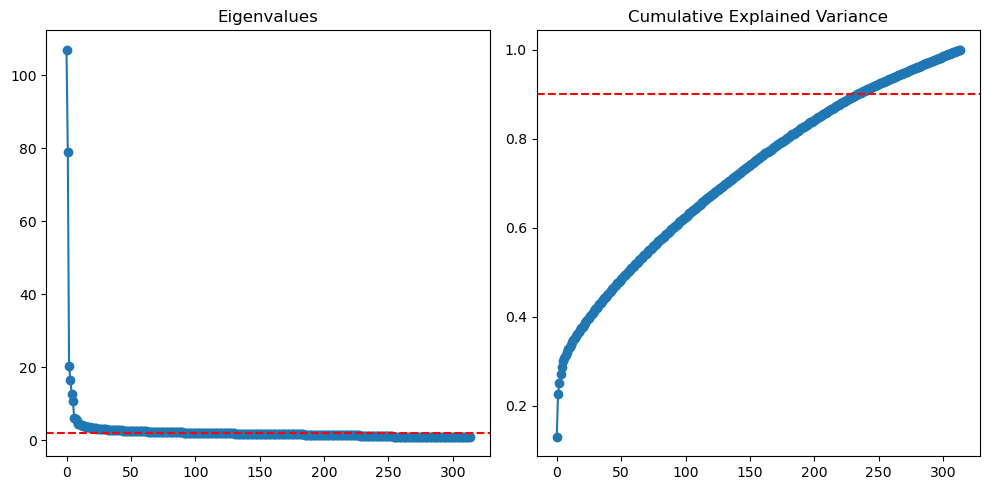

234


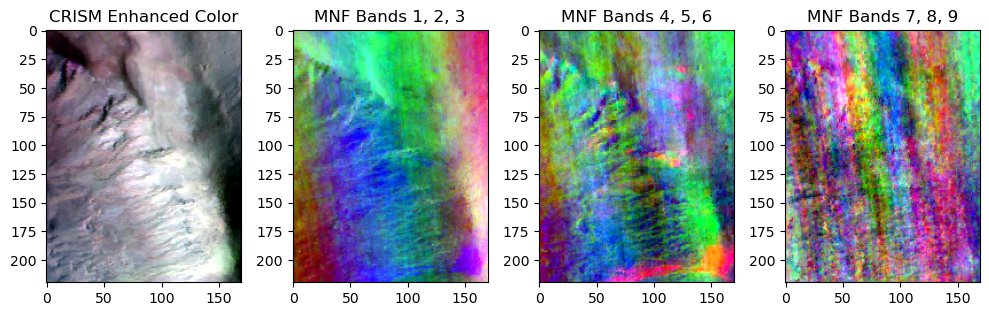

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import spectral as spy

# Function to perform MNF transformation
def mnf_transformation_spy(img_data):
    signal = spy.calc_stats(img_data)
    noise = spy.noise_from_diffs(img_data, direction = 'lowerleft')
    return spy.mnf(signal, noise)

print('\n\tCalculating MNF transformation...\n')
# Perform MNF transformation
mnfr = mnf_transformation_spy(img_data_cleaned)
eigenvalues = mnfr.napc.eigenvalues

# plot the explained variance ratio
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_explained_variance = np.cumsum(explained_variance)

# plot the explained variance ratio
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(eigenvalues, 'o-')
ax[0].set_title('Eigenvalues')
ax[0].axhline(y=2, color='r', linestyle='--')
ax[1].plot(cumulative_explained_variance, 'o-')
ax[1].axhline(y=0.9, color='r', linestyle='--') # plot a vertical line at 90% explained variance
ax[1].set_title('Cumulative Explained Variance')
plt.tight_layout()
plt.show()

# return the number of components that explain 90% of the variance
nc90 = np.argmax(cumulative_explained_variance > 0.9)
print(nc90)

# Reduce the data using number of noise adjust principal components
mnf_data = mnfr.reduce(img_data_cleaned, num=nc90)

# create an RGB image to display
show_img = np.zeros((img_data_cleaned.shape[0], img_data_cleaned.shape[1], 3))
for i, b in enumerate(display_bands):
    band = img_data_cleaned[:,:,b]
    band = clean_crism(band)
    band = stretch_bands(band)
    show_img[:, :, display_bands.index(b)] = band 

# stretch the MNF data
def stretch_rgb(arr):
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)
    arr = (arr - min_val) / (max_val - min_val)
    return arr
# display mnf data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
mnf_display_bands = [(1,2,3), (4,5,6), (7,8,9)]
ax1.imshow(show_img)
ax1.set_title('CRISM Enhanced Color')
mnf_display = stretch_bands(stretch_rgb(mnf_data[:, :, mnf_display_bands[0]]))
ax2.imshow(mnf_display)
ax2.set_title('MNF Bands 1, 2, 3')
mnf_display = stretch_bands(stretch_rgb(mnf_data[:, :, mnf_display_bands[1]]))
ax3.imshow(mnf_display)
ax3.set_title('MNF Bands 4, 5, 6')
mnf_display = stretch_bands(stretch_rgb(mnf_data[:, :, mnf_display_bands[2]]))
ax4.imshow(mnf_display)
ax4.set_title('MNF Bands 7, 8, 9')
plt.tight_layout()
plt.show()


#### Plot some Spectra by thresholding mnf bands

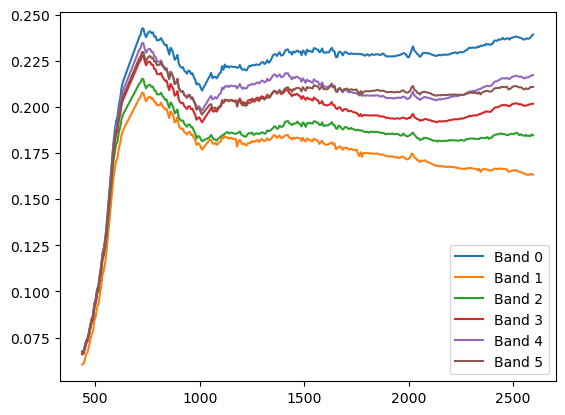

In [4]:
b_list = [0, 1, 2, 3, 4, 5]
fig, ax = plt.subplots()
for b in b_list:
    pixels = np.where(mnf_data[:,:,b] > 2*np.nanstd(mnf_data[:,:,b]))
    # plt.hist(mnf_data[:,:,b].flatten(), bins=100)

    avg_spectrum = np.nanmean(img_data_cleaned[pixels[0], pixels[1],:], axis=(0))
    ax.plot(band_centers_crop, avg_spectrum, label=f'Band {b}')
plt.legend()
plt.show()

### Pixel Purity Index (Spatial Reduction)

The Pixel Purity Index (PPI) is used in the endmember extraction phase to identify pixels in the MNF image that are close to the vertices of the "spectral simplex" (the minimum-bounding N-D polyhedron of the point cloud). Here’s how the PPI works:

1. **Projection onto Random Unit Vectors:**
   - **Process:**
     - The (normalized) MNF data (a matrix where each row represents an N-D pixel) is projected onto a series of random unit vectors. These unit vectors represent random directions in the MNF space.
     - Mathematically, if \($\mathbf{x}_j$\) is a pixel vector and \($\mathbf{y}_i$\) is a random unit vector, the projection is given by:
       $$ \text{Projection}_{\mathbf{y}_i}(\mathbf{x}_j) = (\mathbf{x}_j \cdot \mathbf{y}_i) \mathbf{y}_i $$
     - The dot product \($\mathbf{x}_j \cdot \mathbf{y}_i$) gives the scalar magnitude of the projection.

2. **Extreme Pixels in Each Projection:**
   - **Definition of Extremes:**
     - For each projection, identify the pixels that are at the extremes (i.e., the pixels with the largest or smallest projection magnitudes). These extremes are pixels that lie closest to or farthest from the origin in the direction of \($\mathbf{y}_i$\).
     - Mathematically, this involves finding the maximum and minimum values of \($\mathbf{x}_j \cdot \mathbf{y}_i$\) among all pixels \($\mathbf{x}_j$\) for a given \($\mathbf{y}_i$\).

3. **Cumulative Account of Extremity:**
   - **Counting Extremes:**
     - Maintain a cumulative count of how often each pixel is found to be extreme across all projections. This means keeping track of the number of times each pixel is identified as extreme in any of the random projections.
     - If a pixel is consistently an extreme in many projections, it is considered more "extreme" or "pure."

4. **Extremity-Score and Pixel Purity:**
   - **Relating Extremity to Purity:**
     - The extremity-score (the count of extreme occurrences) is related to pixel purity. In the context of convex geometry, pixels that are extremes in many projections are closer to the vertices of the spectral simplex. These pixels are considered "pure" because they are likely to be representative of the spectral endmembers.
     - This relationship is derived from convex geometry principles, as discussed in Boardman (1993). In simple terms, a pixel that often appears as extreme in various random directions is more likely to be a distinct endmember.

5. **Identification of Purest Pixels:**
   - **Outcome:**
     - The pixels with the highest extremity-scores are identified as the purest pixels in the scene. These pixels are expected to be spectrally distinct and are candidates for endmember selection.

Thus, the PPI is essentially defining the convex polyhedron that bounds the N-D point cloud. Theoretically, you can reconstruct every pixel in the cloud from a linear combination of PPI pixels, making them "endmembers".

#### Summary

In the context of the Spectral Hourglass Workflow, PPI helps identify the most spectrally pure pixels from a hyperspectral image. By computing the angle between each pixel and a set of random vectors, the PPI quantifies how "pure" each pixel is, that is, can it be reconstructed from other spectra in the scene or is it unique. Higher PPI values indicate pixels that are closer to the vertices of the spectral simplex, making them candidates for representing pure spectral signatures, i.e., endmembers. This step simplifies endmember extraction and subsequent analyses.

References:

Boardman J.W., Kruse F.A, and Green R.O., "Mapping Target Signatures via
Partial Unmixing of AVIRIS Data," Pasadena, California, USA, 23 Jan 1995,
URL: https://ntrs.nasa.gov/api/citations/19950027316/downloads/19950027316.pdf

Calculating PPI...

Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  0.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  1.Running 10000 pixel purity iterations...  2.Running 10000 pixel purity iterations...  2.Running 1000

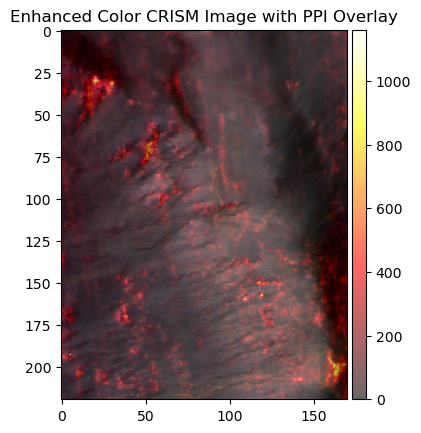

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
thresh = 2.5
# Calculate PPI
print('Calculating PPI...\n')
ppi_map = spy.ppi(mnf_data, niters = 10000, threshold = thresh)
# ppi_map = spy.ppi(mnf_data, niters = 10000, threshold = 2.5, start = ppi_map) #optionally continue

# Create a single subplot
fig, ax = plt.subplots()

# Display the RGB image
ax.imshow(show_img)
ax.set_title('Enhanced Color CRISM Image with PPI Overlay')

# Display the PPI map as a transparent overlay
ppi_im = ax.imshow(np.where(ppi_map>2, ppi_map, 0), cmap='hot', alpha=0.6)  # Adjust alpha for transparency

# Create a divider for the axis to insert the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ppi_im, cax=cax, orientation='vertical')

# Show the plot
plt.show()

### Plot some pure pixels to see what they look like

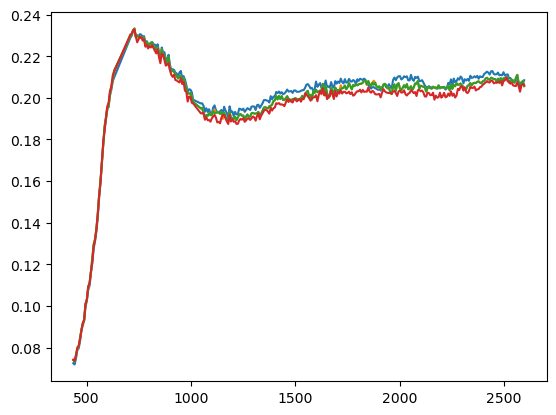

In [6]:
ppi_indexes = np.where((ppi_map > 800) & (ppi_map < 1200))
for i in range(4):
    plt.plot(band_centers_crop, img_data_cleaned[ppi_indexes[0][i], ppi_indexes[1][i],:])
plt.show()


## Endmember Extraction

### Extract ppi vectors

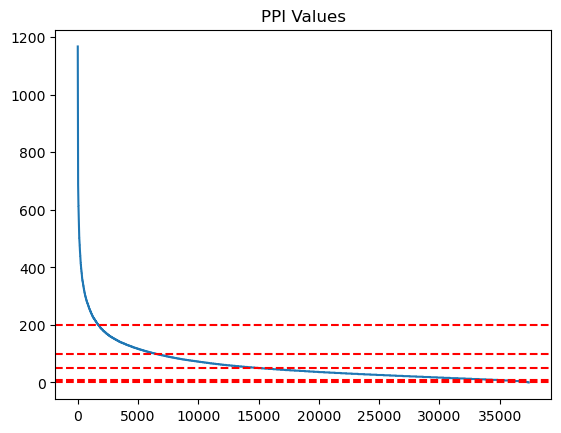

In [7]:
thresh_list = [2, 10, 50, 100, 200]
ppi_values = ppi_map.flatten()
ppi_values_sorted = np.sort(ppi_values)[::-1]
plt.plot(ppi_values_sorted)
for thresh in thresh_list:
    plt.axline((0, thresh), slope=0, color='r', linestyle='--')
plt.title('PPI Values')
plt.show()

## Export the vectors for visualization

In [8]:
# export ppi_vectors to a csv file
thresh = 180
ppi_indexes = np.where(ppi_map > thresh)
print(f'{ppi_indexes[0].shape[0]} ppi values above threshold')

ppi_vectors = mnf_data[ppi_indexes[0], ppi_indexes[1], :]
ppi_vectors.shape

import pandas as pd
ppi_vectors_df = pd.DataFrame(ppi_vectors)
ppi_vectors_df.to_csv(f'ppi_vectors_gt{thresh}.csv', index=False)

2103 ppi values above threshold


# Use the ND-Visualizer to select endmember points
#### from the terminal:
python nd_visualizer.py

## Load back in the selected points

In [11]:
import json
import pandas as pd
file_path = '/Users/shane/code/packages/spectral_hourglass/ppi_vectors_gt180.json'
with open(file_path, 'rb') as file:
    endmember_groups = json.load(file)

edf = pd.DataFrame(endmember_groups)
edf


,Class 0,Class 1,Class 2
indices,"[1536, 1537, 1538, 1539, 1540, 1029, 1030, 103...","[2054, 2055, 2056, 7, 14, 15, 16, 2090, 2095, ...","[2048, 2049, 2050, 2051, 2052, 1541, 1542, 205..."
color,"[0.10196078431372549, 0.5333333333333333, 0.27...","[0.2823529411764706, 0.6980392156862745, 0.627...","[0.6549019607843137, 0.8941176470588236, 0.2]"


## Show the selected pixels on the image

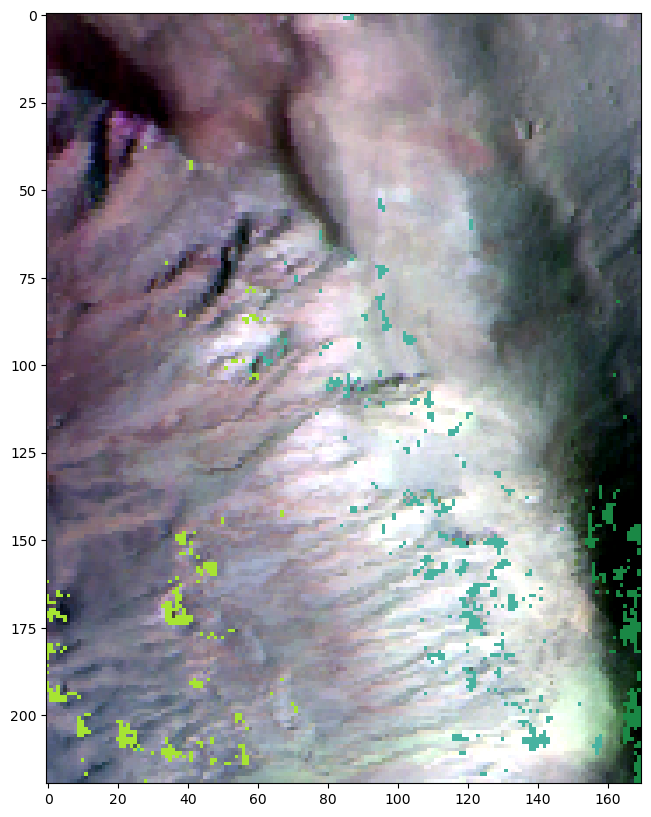

In [12]:
from matplotlib.colors import to_rgb

m_ = []
for c in edf.keys():
    m = np.zeros((img_data_cleaned.shape[0], img_data_cleaned.shape[1]), dtype=bool)
    # make a mask of color edf[c]['color'] for pixel locations in ppi_indices
    ppi_indices = edf[c]['indices']
    mc = edf[c]['color']
    for i in range(len(ppi_indices)):
        i0 = ppi_indices[i]
        m[ppi_indexes[0][i0], ppi_indexes[1][i0]] = True
    m_.append((m, mc))

# Plot the original image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(show_img)

# Overlay each mask with respective color and alpha channel
for m, color in m_:
    colored_mask = np.zeros_like(show_img)
    alpha_channel = np.zeros((show_img.shape[0], show_img.shape[1]))

    # Convert color to RGB
    rgb = to_rgb(color)
    colored_mask[:, :, 0] = rgb[0]
    colored_mask[:, :, 1] = rgb[1]
    colored_mask[:, :, 2] = rgb[2]
    
    alpha_channel[m] = 1  # Set alpha to 1 for masked pixels
    
    # Combine color and alpha
    rgba_mask = np.dstack((colored_mask, alpha_channel))
    ax.imshow(rgba_mask)

plt.show()

## Plot spectra of the endmember pixels

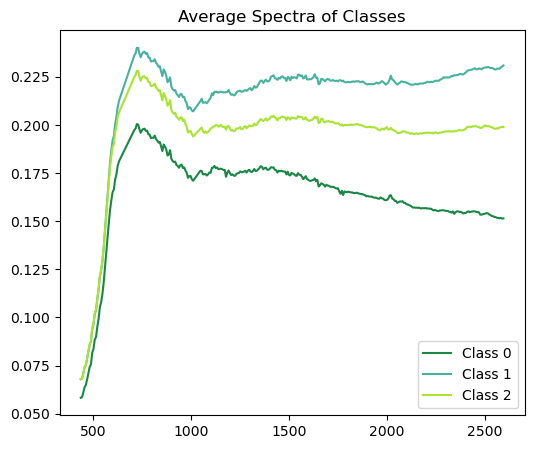

In [13]:
class_avg_spec = []
colors = []
for c in edf.keys():
    specs = []
    ppi_indices = edf[c]['indices']
    for i in ppi_indices:
        r = ppi_indexes[0][i]
        c_ = ppi_indexes[1][i]
        specs.append(img_data_cleaned[r, c_,:])
    # get average spectra
    class_avg_spec.append(np.nanmean(specs, axis=0))
    colors.append(edf[c]['color'])

fig, ax = plt.subplots(figsize=(6,5))
for color_, spec, name in zip(colors, class_avg_spec, edf.keys()): 
    ax.plot(band_centers_crop, spec, color = np.array(color_), label=name)
plt.title('Average Spectra of Classes')
plt.legend()
plt.show()

# Identification
At this stage, we would iterate on this process, refining our endmembers, removing pixels that are just noise, consolidating similar looking endmembers (e.g., only different in brightness not shape) and identify each endmember as specific minerals or compositional classes.

# Classification
## Spectral Angle Mapper
The Spectral Angle Mapper (SAM) is a spectral classification technique that compares the spectral similarity between image spectra and reference spectra (or endmembers). This method treats spectra as vectors in a multi-dimensional space, where each dimension corresponds to a specific wavelength band. The "spectral angle" is the angle between the reference spectra and the image spectra in the N-dimensional space. One benefit of this approach is that differences in the overal brightness of the spectra (the magnitude of the vectors) won't affect the their spectral similarity with the reference spectra.

#### Mathematical Formulation

Given two spectra, \($\mathbf{t}$\) (target spectrum) and \($\mathbf{r}$\) (reference spectrum), each represented as vectors in an \(n\)-dimensional space (where \(n\) is the number of wavelength bands), the spectral angle \($\theta$\) between these two vectors is defined as:

$$
\cos(\theta) = \frac{\mathbf{t} \cdot \mathbf{r}}{\|\mathbf{t}\| \|\mathbf{r}\|}
$$

Here:
- \($\mathbf{t} \cdot \mathbf{r}$\) is the dot product of the two vectors.
- \($\|\mathbf{t}\|$\) and \($\|\mathbf{r}\|$\) are the magnitudes (or norms) of the vectors.

The angle \($\theta$\) can be computed as:

$$
\theta = \cos^{-1}\left( \frac{\sum_{i=1}^{n} t_i r_i}{\sqrt{\sum_{i=1}^{n} t_i^2} \sqrt{\sum_{i=1}^{n} r_i^2}} \right)
$$

#### Interpretation

- **Spectral Similarity**: The smaller the angle \($\theta$\), the more similar the spectra are. An angle of 0° indicates identical spectral shapes, while larger angles indicate greater spectral dissimilarity.
- **Scale Invariance**: SAM is insensitive to the magnitude of the spectra, making it robust to variations in illumination and albedo.

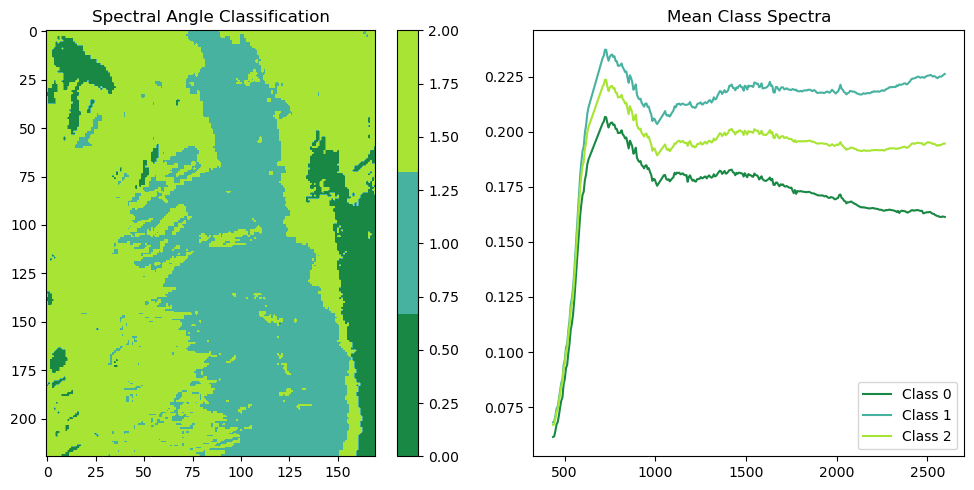

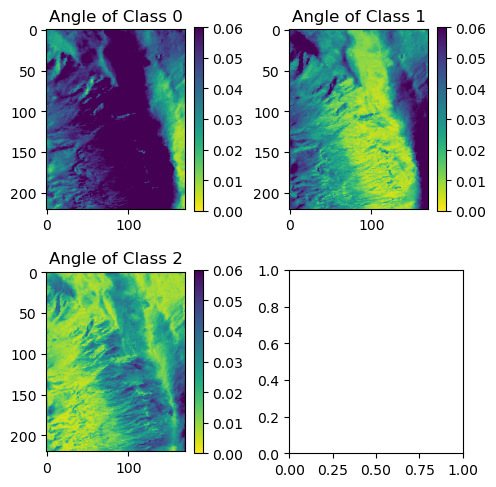

In [14]:
import numpy as np
from matplotlib.colors import ListedColormap

angles = spy.spectral_angles(img_data_cleaned, np.array(class_avg_spec))
classification = np.argmin(angles, axis=2)

# calculate the average spectrum for each class
avg_spec = []
colors = []
for i, c in enumerate(edf.keys()):
    specs = []
    ri, ci = np.asarray(classification == i).nonzero()
    avg_spec.append(np.nanmean(img_data_cleaned[ri, ci, :], axis=0))
    colors.append(edf[c]['color'])

# create a custom color map based on the class colors
my_cmap = ListedColormap(colors)

# Show the classification result
fig, ax = plt.subplots(1,2,figsize=(10,5))
im_plot = ax[0].imshow(classification, cmap=my_cmap)
fig.colorbar(im_plot, ax=ax[0])
ax[0].set_title('Spectral Angle Classification')
for color_, spec, name in zip(colors, avg_spec, edf.keys()): 
    ax[1].plot(band_centers_crop, spec, color = np.array(color_), label=name)
ax[1].legend()
ax[1].set_title('Mean Class Spectra')
plt.tight_layout()
plt.show()

# Plot the spectral angle maps
class_labels = list(edf.keys())
# Create spectral angle maps
angle_maps = {}
for i, label in enumerate(class_labels):
    angle_maps[label] = angles[:, :, i]

num_rows = np.ceil(len(class_labels)**0.5).astype(int)
num_cols = np.ceil(len(class_labels)**0.5).astype(int)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.5))
for ax, (label, angle_map) in zip(axes.ravel(), angle_maps.items()):
    im = ax.imshow(angle_map, cmap='viridis_r', vmin=0, vmax=0.06)
    ax.set_title(f'Angle of {label}')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Multi-Layer Perceptron Classification
Multi-Layer Perceptrons (MLPs) are a type of feedforward artificial neural network commonly used for classification tasks, including hyperspectral image classification. MLPs consist of an input layer, one or more hidden layers, and an output layer, with each layer comprising multiple interconnected neurons.

#### Context: Hyperspectral Image Classification

In the context of classifying a hyperspectral image with already identified in-scene endmember spectral patches, MLPs can effectively learn the complex relationships and patterns in the high-dimensional spectral data. Here's a brief overview of how MLPs are applied:

1. **Input Layer**:
   - Each pixel in a hyperspectral image is represented by a spectral vector, where each component corresponds to the reflectance value at a specific wavelength.
   - These spectral vectors serve as input to the MLP.

2. **Hidden Layers**:
   - The hidden layers consist of neurons that apply learned weights and biases to the input data, followed by non-linear activation functions.
   - These layers capture intricate patterns and interactions within the spectral data that are critical for accurate classification.

3. **Output Layer**:
   - The output layer produces class probabilities for each input pixel, indicating the likelihood of the pixel belonging to each predefined class.
   - The number of neurons in the output layer corresponds to the number of endmember classes.

4. **Training**:
   - The MLP is trained using labeled spectral patches of the endmembers, where the true class labels are known.
   - The training process involves adjusting the weights and biases to minimize the classification error using a suitable loss function and optimization algorithm (e.g., backpropagation with gradient descent).

5. **Classification**:
   - Once trained, the MLP can classify each pixel in the hyperspectral image by predicting the class label based on the learned model.
   - The output is a classified image where each pixel is assigned to one of the endmember classes.

### Advantages

- **Non-Linearity**: MLPs can model non-linear relationships in spectral data, improving classification accuracy.
- **High Dimensionality**: They can handle the high-dimensional nature of hyperspectral data effectively.
- **Flexibility**: MLPs can be adapted to various classification tasks by changing the network architecture and training parameters.

### More information on MLPs and a basic understanding of neural networks

https://youtu.be/aircAruvnKk?si=heIjLbP58fx9Q63P


Training accuracy: 0.98
Test accuracy: 0.96


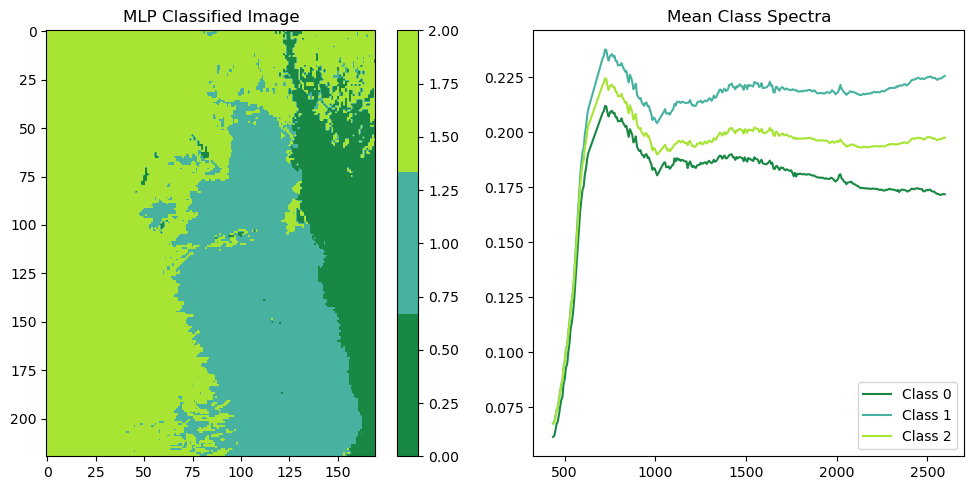

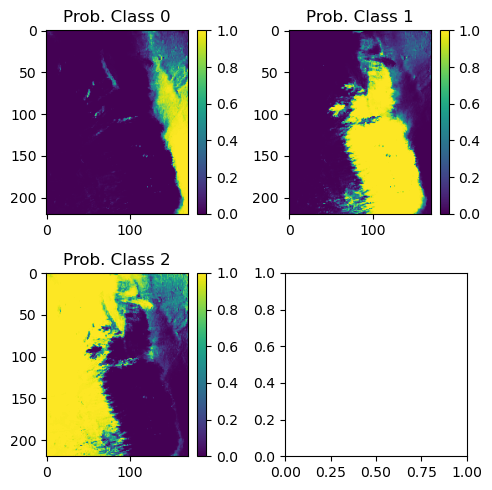

In [15]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare data for MLP
features = []
labels = []

feature_cube = img_data_cleaned

for c in edf.keys():
    ppi_indices = edf[c]['indices']
    label = c
    for i in ppi_indices:
        r = ppi_indexes[0][i]
        c = ppi_indexes[1][i]
        features.append(feature_cube[r, c, :])
        labels.append(label)

features = np.array(features)
labels = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train MLPClassifier
'''
Adjust the hidden layer size or the training iterations until accuracy < 1 to avoid overfitting
'''
mlp = MLPClassifier(hidden_layer_sizes=(7,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate the model
print(f"Training accuracy: {mlp.score(X_train, y_train):.2f}")
print(f"Test accuracy: {mlp.score(X_test, y_test):.2f}")

# Classify the entire image
img_flat = feature_cube.reshape(-1, feature_cube.shape[-1])
img_flat_scaled = scaler.transform(img_flat)
probabilities = mlp.predict_proba(img_flat_scaled)
predictions = mlp.predict(img_flat_scaled)
classified_img = predictions.reshape(feature_cube.shape[:2])

# Mapping from class label strings to integers
class_labels = list(edf.keys())
label_to_int = {label: idx for idx, label in enumerate(class_labels)}
classified_img_int = np.array([label_to_int[i] for i in classified_img.flatten()])
classified_img_int = classified_img_int.reshape(classified_img.shape)

# Create probability maps
prob_maps = {}
for i, label in enumerate(class_labels):
    prob_maps[label] = probabilities[:, i].reshape(feature_cube.shape[:2])

# calculate the average spectrum for each class
avg_spec = []
colors = []
for c in edf.keys():
    specs = []
    ri, ci = np.asarray(classified_img == c).nonzero()
    avg_spec.append(np.nanmean(img_data_cleaned[ri, ci, :], axis=0))
    colors.append(edf[c]['color'])

# Plot the classified image and spectra
fig, ax = plt.subplots(1,2,figsize=(10,5))
im_plot = ax[0].imshow(classified_img_int, cmap=my_cmap)  # 'tab10' provides distinct colors for up to 10 classes
fig.colorbar(im_plot, ax=ax[0])
ax[0].set_title("MLP Classified Image")
for color_, spec, name in zip(colors, avg_spec, edf.keys()): 
    ax[1].plot(band_centers_crop, spec, color = np.array(color_), label=name)
ax[1].legend()
ax[1].set_title('Mean Class Spectra')
plt.tight_layout()
plt.show()

# Plot the probability maps
num_rows = np.ceil(len(class_labels)**0.5).astype(int)
num_cols = np.ceil(len(class_labels)**0.5).astype(int)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.5))
for ax, (label, prob_map) in zip(axes.ravel(), prob_maps.items()):
    im = ax.imshow(prob_map, cmap='viridis', vmin=0, vmax=1)
    ax.set_title(f'Prob. {label}')
    plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Unsupervised clustering with k-means
The k-means algorithm takes an iterative approach to generating clusters. The parameter k specifies the desired number of clusters to generate. The algorithm begins with an initial set of cluster centers (e.g., results from cluster). Each pixel in the image is then assigned to the nearest cluster center (using distance in N-space as the distance metric) and each cluster center is then recomputed as the centroid of all pixels assigned to the cluster. This process repeats until a desired stopping criterion is reached (e.g., max number of iterations).

spectral:INFO: k-means iteration 1 - 33115 pixels reassigned.
spectral:INFO: k-means iteration 2 - 2601 pixels reassigned.
spectral:INFO: k-means iteration 3 - 1010 pixels reassigned.
spectral:INFO: k-means iteration 4 - 420 pixels reassigned.
spectral:INFO: k-means iteration 5 - 308 pixels reassigned.
spectral:INFO: k-means iteration 6 - 249 pixels reassigned.
spectral:INFO: k-means iteration 7 - 207 pixels reassigned.
spectral:INFO: k-means iteration 8 - 166 pixels reassigned.
spectral:INFO: k-means iteration 9 - 121 pixels reassigned.
spectral:INFO: k-means iteration 10 - 96 pixels reassigned.
spectral:INFO: k-means iteration 11 - 78 pixels reassigned.
spectral:INFO: k-means iteration 12 - 61 pixels reassigned.
spectral:INFO: k-means iteration 13 - 46 pixels reassigned.
spectral:INFO: k-means iteration 14 - 38 pixels reassigned.
spectral:INFO: k-means iteration 15 - 34 pixels reassigned.
spectral:INFO: k-means iteration 16 - 12 pixels reassigned.
spectral:INFO: k-means iteration 17 

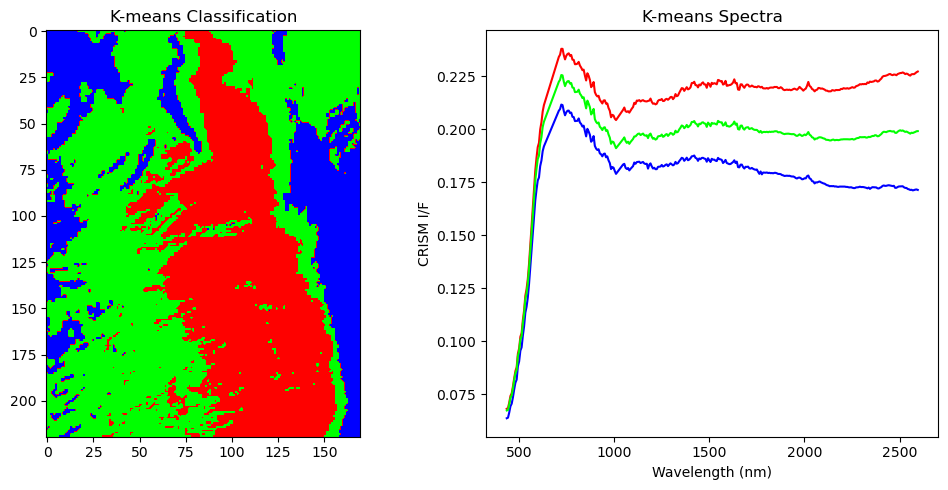

In [16]:
import matplotlib.colors as mcolors

start_clusters = np.array(class_avg_spec)
'''
start clusters is an optional parameter, we could use this method with 
no starting clusters, try it and see the difference between the two methods
'''
num_clusters = start_clusters.shape[0] #8 # k parameter
niters = 30 # maximum number of iterations
(m, c) = spy.kmeans(img_data_cleaned, num_clusters, niters, start_clusters = start_clusters)

# plot the results
# Get a colormap
cmap = plt.get_cmap('brg')
colors = cmap(np.linspace(0, 1, num_clusters))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(m,cmap=mcolors.ListedColormap(colors))
ax[0].set_title('K-means Classification')
for i, spec in enumerate(c):
    ax[1].plot(band_centers_crop, spec, color=colors[i])
ax[1].set_ylabel('CRISM I/F')
ax[1].set_xlabel('Wavelength (nm)')
ax[1].set_title('K-means Spectra')
plt.tight_layout()
plt.show()